# UrbanSoundClassifier: Environmental Sound Classification

This project trains a neural network to classify environmental sounds using the [UrbanSound8K dataset](https://urbansounddataset.weebly.com/urbansound8k.html). The dataset contains 8,732 labeled sound excerpts (<=4s) of urban sounds across 10 classes, such as dog bark, car horn, and jackhammer.

## 1. Data Loading
Load the metadata from the UrbanSound8K dataset to understand the structure and class distribution.

In [1]:
import pandas as pd

In [ ]:
metadata = pd.read_csv('data/UrbanSound8K/metadata/UrbanSound8K.csv')
metadata.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


## 2. Exploratory Data Analysis (EDA)
Analyze the distribution of classes to check for imbalances and visualize the results.

Class Distribution:
 class
dog_bark            1000
children_playing    1000
air_conditioner     1000
street_music        1000
jackhammer          1000
engine_idling       1000
drilling            1000
siren                929
car_horn             429
gun_shot             374
Name: count, dtype: int64


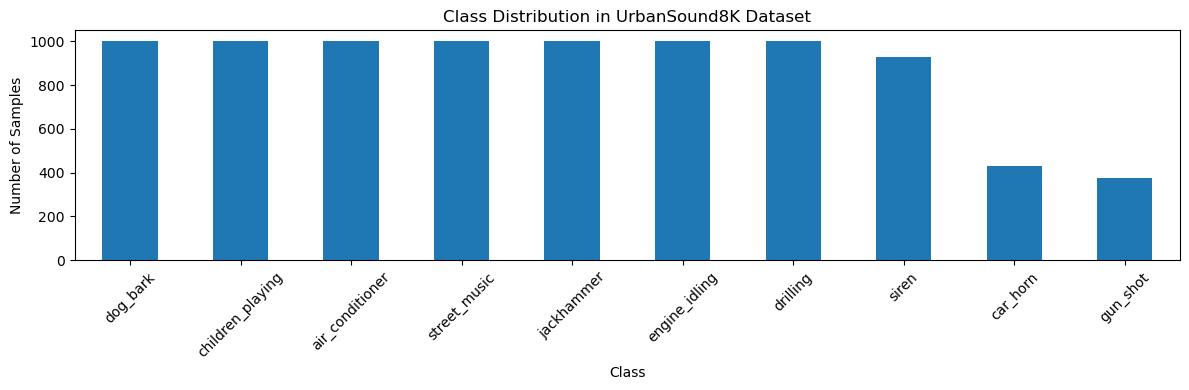

In [3]:
import matplotlib.pyplot as plt

# Class distribution
class_counts = metadata['class'].value_counts()
print("Class Distribution:\n", class_counts)

# Visualize class distribution
plt.figure(figsize=(12, 4))
class_counts.plot(kind='bar')
plt.title('Class Distribution in UrbanSound8K Dataset')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
import IPython.display as ipd
filename = 'data/UrbanSound8K/audio/fold1/102106-3-0-0.wav'
ipd.Audio(filename)

Audio data shape: (36162,)
Sample rate: 22050


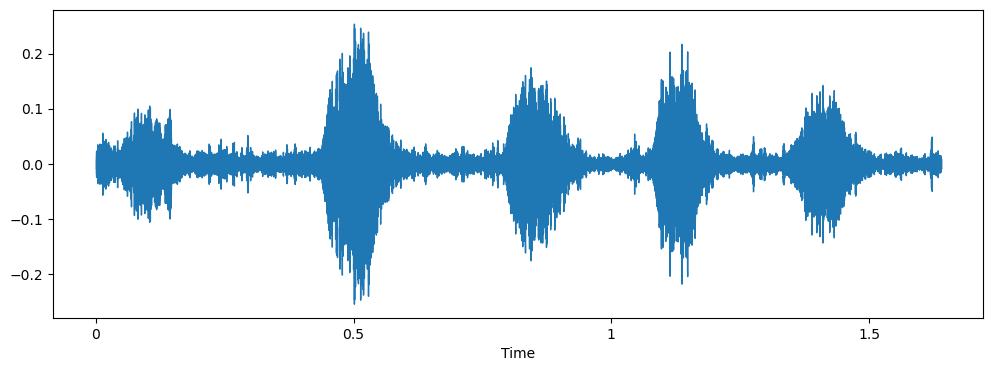

In [5]:
import librosa

librosa_audio_data, librosa_sr = librosa.load(filename)
print("Audio data shape:", librosa_audio_data.shape) # the number of samples
print("Sample rate:", librosa_sr) # the sampling frequency

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
librosa.display.waveshow(librosa_audio_data, sr=librosa_sr)
plt.show()

Audio data shape: (72324, 2)
Sample rate: 44100


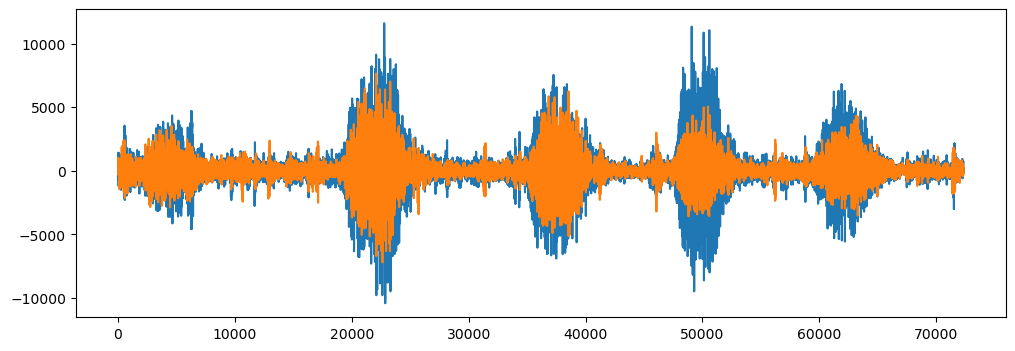

In [6]:
from scipy.io import wavfile as wav

wav_sr, wav_audio_data = wav.read(filename)
print("Audio data shape:", wav_audio_data.shape)
print("Sample rate:", wav_sr)

plt.figure(figsize=(12, 4))
plt.plot(wav_audio_data)
plt.show()

## 3. Feature Extraction
Extract audio features (MFCCs) from audio files for model training.

In [7]:
import numpy as np

n_mfcc = 70

def features_extractor(file_path):
    audio_data, sample_rate = librosa.load(file_path)
    n_fft = min(len(audio_data), 2048)
    mfccs_features = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=n_mfcc, n_fft=n_fft)
    mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)
    return mfccs_scaled_features

In [ ]:
import os
from tqdm import tqdm

audio_dataset_path = 'data/UrbanSound8K/audio/'

extracted_features = []
for idx_num, row in tqdm(metadata.iterrows()):
    file_name = f'{audio_dataset_path}/fold{row["fold"]}/{row["slice_file_name"]}'
    final_class_labels = row["class"]
    try:
        data = features_extractor(file_name)
        extracted_features.append([data, final_class_labels])
    except Exception as e:
        print(f"Error processing {file_name}: {e}")
        continue

8732it [01:48, 80.50it/s] 


In [9]:
extracted_features_df = pd.DataFrame(extracted_features, columns=["features", "class"])
extracted_features_df

,features,class
0,"[-211.93698, 62.581207, -122.81313, -60.745293...",dog_bark
1,"[-417.0052, 99.336624, -42.995586, 51.073326, ...",children_playing
2,"[-452.39316, 112.36253, -37.578068, 43.19586, ...",children_playing
3,"[-406.47922, 91.1966, -25.043558, 42.78452, 11...",children_playing
4,"[-439.63873, 103.86223, -42.658787, 50.690277,...",children_playing
...,...,...
8727,"[-391.3721, 125.36239, -40.634056, 25.899754, ...",car_horn
8728,"[-339.42715, 76.409096, -35.30988, 41.984035, ...",car_horn
8729,"[-297.31534, 102.09026, -36.75108, 26.816488, ...",car_horn
8730,"[-336.92386, 115.313896, -44.8471, 24.968985, ...",car_horn


In [10]:
X = np.array(extracted_features_df["features"].to_list())
y = np.array(extracted_features_df["class"].to_list())

In [11]:
X.shape

(8732, 70)

In [12]:
y = pd.get_dummies(y, dtype=int)
pd.DataFrame(y).head()

,air_conditioner,car_horn,children_playing,dog_bark,drilling,engine_idling,gun_shot,jackhammer,siren,street_music
0,0,0,0,1,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0


In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
X_train.shape

(6985, 70)

In [15]:
X_test.shape

(1747, 70)

In [16]:
y_train.shape

(6985, 10)

In [17]:
y_test.shape

(1747, 10)

## 4. Model Training
Train a neural network using the extracted features.

In [18]:
import tensorflow as tf
print(tf.__version__)

2.18.1


In [19]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.optimizers import Adam
from sklearn import metrics

In [20]:
num_labels = y.shape[1]

In [21]:
model = Sequential([
    Input(shape=(n_mfcc,)),
    Dense(100),
    Activation('relu'),
    Dropout(0.5),
    Dense(200),
    Activation('relu'),
    Dropout(0.5),
    Dense(100),
    Activation('relu'),
    Dropout(0.5),
    Dense(num_labels),
    Activation('softmax')
])

In [22]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 100)            │         7,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,410 (189.10 KB)

 Trainable params: 48,410 (189.10 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
from keras.callbacks import ModelCheckpoint
from datetime import datetime 

checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification.keras', verbose=1, save_best_only=True)
start = datetime.now()

history = model.fit(X_train, y_train, batch_size=64, epochs=200, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)

duration = datetime.now() - start
print("\nTraining completed in time: ", duration)

Epoch 1/200
 80/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1098 - loss: 31.9258 
Epoch 1: val_loss improved from inf to 2.29096, saving model to saved_models/audio_classification.keras
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1120 - loss: 27.7033 - val_accuracy: 0.1391 - val_loss: 2.2910
Epoch 2/200
 85/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1157 - loss: 3.7271 
Epoch 2: val_loss improved from 2.29096 to 2.28849, saving model to saved_models/audio_classification.keras
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1165 - loss: 3.6071 - val_accuracy: 0.1202 - val_loss: 2.2885
Epoch 3/200
 85/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1120 - loss: 2.5290 
Epoch 3: val_loss improved from 2.28849 to 2.28033, saving model to saved_models/audio_classification.keras
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1129 - loss: 2.5167 - val_accuracy: 0.1196 - val_loss: 2.2803
Epoch 4/200
 99/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

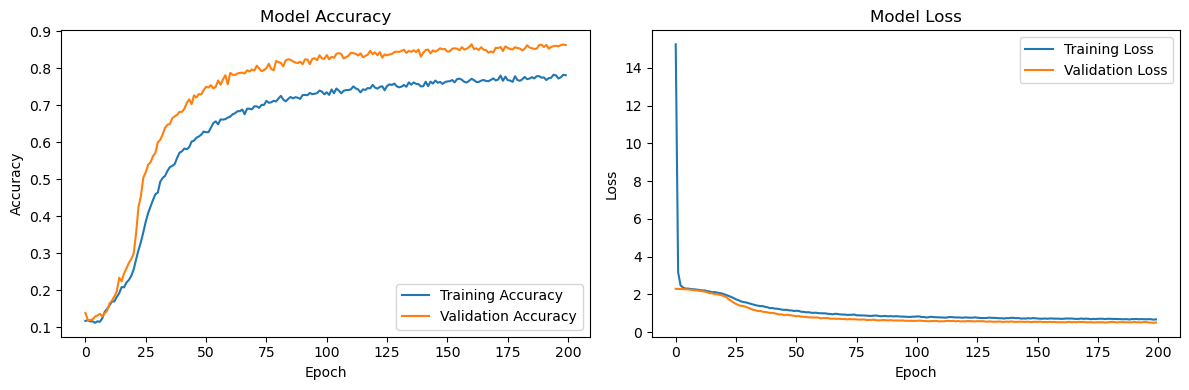

In [25]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [26]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step - accuracy: 0.8511 - loss: 0.5353
Test accuracy: 0.8626


## 5. Model Prediction
Test the model by predicting the class of a sample audio file and play the audio for verification.

In [ ]:
audio_file = "data/UrbanSound8K/audio/fold9/180156-1-4-0.wav"
features = features_extractor(audio_file)
X_new = np.array([features])
ipd.Audio(audio_file)

In [28]:
class_names = pd.get_dummies(extracted_features_df['class']).columns.tolist()
class_names

['air_conditioner',
 'car_horn',
 'children_playing',
 'dog_bark',
 'drilling',
 'engine_idling',
 'gun_shot',
 'jackhammer',
 'siren',
 'street_music']

In [29]:
y_pred_prob = model.predict(X_new)
y_pred = np.argmax(y_pred_prob, axis=1)
predicted_classes = [class_names[idx] for idx in y_pred]
predicted_classes[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


'car_horn'